# HPH第一版实验

### 思路

*id统计相关*
1. item_id, shop_id的交易量, 交易率
2. item_id, shop_id7天是否新出现, 3天是否新出现

In [142]:
import sys
sys.path.append("..")
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime


%matplotlib inline
offline_df = pd.read_table('../../round1_ijcai_18_train_20180301.txt', sep=' ')
# online_df = pd.read_table('../../round1_ijcai_18_test_a_20180301.txt', sep=' ')

# 1 数据集统一处理

In [143]:
# 时间处理: 分离天, 星期几, 上中下午/晚上, 小时数

from datetime import datetime

def extract_date(x):
    d = datetime.fromtimestamp(x)
    return d.strftime('%Y-%m-%d')
def extract_weekday(x):
    d = datetime.fromtimestamp(x)
    return d.weekday()
def extract_hour(x):
    d = datetime.fromtimestamp(x)
    return d.hour

offline_df['date'] = offline_df['context_timestamp'].apply(lambda x: extract_date(x))
offline_df['weekday'] = offline_df['context_timestamp'].apply(lambda x: extract_weekday(x))
offline_df['hour'] = offline_df['context_timestamp'].apply(lambda x: extract_hour(x))

In [267]:
# id是否重复信息
le = preprocessing.LabelEncoder()
offline_df['item_id_dup'] = le.fit_transform(offline_df['item_id'].duplicated())
offline_df['shop_id_dup'] = le.fit_transform(offline_df['shop_id'].duplicated())
offline_df['item_brand_id_dup'] = le.fit_transform(offline_df['item_brand_id'].duplicated())
offline_df['user_id_dup'] = le.fit_transform(offline_df['user_id'].duplicated())



In [5]:
# 异常值丢弃, 100条以内

offline_df['shop_score_service'] = offline_df['shop_score_service'].map(lambda x: x if x > 0 else float("nan"))
offline_df['shop_score_delivery'] = offline_df['shop_score_delivery'].map(lambda x: x if x > 0 else float("nan"))
offline_df['shop_score_description'] = offline_df['shop_score_description'].map(lambda x: x if x > 0 else float("nan"))
offline_df['shop_review_positive_rate']  = offline_df['shop_review_positive_rate'].map(lambda x: x if x > 0 else float("nan"))
offline_df = offline_df.dropna()

In [144]:
# 统计信息附加

def getColTradeRate(df, idCol):
    rateCol = idCol + '_tr'
    pvCol = idCol + '_pv'
    try:
        del df[rateCol]
        del df[pvCol]
    except:
        pass
    a = offline_df.groupby([idCol]).agg({'is_trade':'sum'})
    b = offline_df.groupby([idCol]).agg({'is_trade':'size'})
    c = a.join(b, lsuffix="_sum", rsuffix="_size")
    c[rateCol] = c['is_trade_sum'] / c['is_trade_size']
    c[pvCol] = c['is_trade_size']
    return offline_df.join(c[[rateCol, pvCol]], on=idCol)
    

# 各类id的 交易量, 交易率
offline_df = getColTradeRate(offline_df, 'item_city_id')
offline_df = getColTradeRate(offline_df, 'item_id')
offline_df = getColTradeRate(offline_df, 'shop_id')
offline_df = getColTradeRate(offline_df, 'item_brand_id')
offline_df = getColTradeRate(offline_df, 'user_occupation_id')


In [145]:
# 分桶
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

offline_df['item_city_id_pv_cut'] = pd.cut(offline_df['item_city_id_pv'].values, bins=10, retbins=False)
offline_df['item_id_pv_cut'] = pd.cut(offline_df['item_id_pv'].values, bins=10, retbins=False)
offline_df['shop_id_pv_cut'] = pd.cut(offline_df['shop_id_pv'].values, bins=10, retbins=False)
offline_df['item_brand_id_pv_cut'] = pd.cut(offline_df['item_brand_id_pv'].values, bins=10, retbins=False)
offline_df['user_occupation_id_pv_cut'] = pd.cut(offline_df['user_occupation_id_pv'].values, bins=10, retbins=False)

offline_df['item_city_id_pv_cut'] = le.fit_transform(offline_df['item_city_id_pv_cut'].copy())
offline_df['item_id_pv_cut'] = le.fit_transform(offline_df['item_id_pv_cut'].copy())
offline_df['shop_id_pv_cut'] = le.fit_transform(offline_df['shop_id_pv_cut'].copy())
offline_df['item_brand_id_pv_cut'] = le.fit_transform(offline_df['item_brand_id_pv_cut'].copy())
offline_df['user_occupation_id_pv_cut'] = le.fit_transform(offline_df['user_occupation_id_pv_cut'].copy())

In [237]:
# 归一化 连续值

def fillempty(df, name, val):
    return df[name].map(lambda x: val if x < 0 else x )

num_ids = ['shop_score_service', 'shop_score_delivery', 'shop_score_description', 
           'shop_review_positive_rate', 'item_city_id_tr', 'item_id_tr',
           'shop_id_tr', 'item_brand_id_tr', 'user_occupation_id_tr']

for col in num_ids:
    offline_df[col + '_scaled'] = fillempty(offline_df, col, -0.000000000001)
    

In [ ]:
import sklearn
help(sklearn.preprocessing)

In [ ]:
# standardization and scaling

from sklearn import preprocessing

def scale(df, idCol):
    min_max_scaler = preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df[idCol].values.reshape(-1, 1))
    return pd.Series(a.reshape(1, -1)[0])

# 令数据再少一些?
offline_df['shop_score_service_scaled'] = scale(offline_df, 'shop_score_service')
offline_df['shop_score_delivery_scaled'] = scale(offline_df, 'shop_score_delivery')
offline_df['shop_score_description_scaled'] = scale(offline_df, 'shop_score_description')
offline_df['shop_review_positive_rate_scaled'] = scale(offline_df, 'shop_review_positive_rate')
offline_df['item_city_id_tr_scaled'] = scale(offline_df, 'item_city_id_tr')
offline_df['item_id_tr_scaled'] = scale(offline_df, 'item_id_tr')
offline_df['shop_id_tr_scaled'] = scale(offline_df, 'shop_id_tr')
offline_df['item_brand_id_tr_scaled'] = scale(offline_df, 'item_brand_id_tr')
offline_df['user_occupation_id_scaled'] = scale(offline_df, 'user_occupation_id_tr')

# offline_df = offline_df.dropna()

In [ ]:
offline_df

# 2 生成矩阵数据

In [9]:
# 原始类目特征表示
from tqdm import tqdm

raw_feat = []
for i, row in tqdm(offline_df.iterrows(), total=len(offline_df)):
    feat = {}
    feat['it_prc_l'] = str(row.item_price_level)
    feat['it_sls_l'] = str(row.item_sales_level)
    feat['it_cll_l'] = str(row.item_collected_level)
    feat['it_pv_l'] = str(row.item_pv_level)
    feat['sp_rvn_l'] = str(row.shop_review_num_level)
    feat['ct_pg'] = str(row.context_page_id)
    feat['it_city'] = str(row.item_city_id)
    feat['it_brd'] = str(row.item_brand_id)
    feat['sp_id'] = str(row.shop_id)
    feat['it_city_pvc'] = str(row.item_city_id_pv_cut.right)
    feat['it_pvc'] = str(row.item_id_pv_cut.right)
    feat['sp_id_pvc'] = str(row.shop_id_pv_cut.right)
    feat['it_brd_id_pvc'] = str(row.item_brand_id_pv_cut.right)
    feat['u_occp_pvc'] = str(row.user_occupation_id_pv_cut.right)
    feat['weekday'] = str(row.weekday)
    feat['hour'] = str(row.hour)
    raw_feat.append(feat)


100%|██████████| 478020/478020 [01:50<00:00, 4340.08it/s]


In [10]:
# 生成矩阵
from sklearn.feature_extraction import DictVectorizer
from sklearn.externals import joblib

vec = DictVectorizer()
cate_features = vec.fit_transform(raw_feat)

# joblib.dump(vec, 'model/vectorizer.m')

In [17]:
# 数字特征处理
num_cols = ['shop_score_service_scaled', 
 'shop_score_delivery_scaled', 
 'shop_score_description_scaled', 
 'shop_review_positive_rate_scaled', 
 'item_city_id_tr_scaled', 'item_id_tr_scaled', 
 'shop_id_tr_scaled', 'item_brand_id_tr_scaled', 
 'user_occupation_id_scaled'
]

num_features = offline_df[num_cols].as_matrix()

In [18]:
# 特征合并, label列提取
from scipy import sparse as sp

# model_features = sp.hstack([cate_features, num_features])
# model_features = cate_features
model_features = num_features
model_targets = offline_df.is_trade.values
print(model_features.shape, model_targets.shape)

(478020, 9) (478020,)


In [20]:
# 最终生成数据

used = 78261
X, y = model_features.toarray()[:used], model_targets[:used]

offset = int(used * (1 - 0.05))
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

In [ ]:
offline_df.columns

In [ ]:
X.columns

In [274]:
used = 78261
X = offline_df[['date', 'item_id', 'item_id_dup', 'shop_id_dup', 'item_brand_id_dup', 'user_id_dup',
       'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level',
       'item_collected_level', 'item_pv_level', 'item_id_pv_cut', 'shop_id_pv_cut',
       'user_occupation_id_pv_cut', 'user_id', 'user_gender_id', 'weekday', 'hour',
       'user_age_level', 'user_occupation_id', 'user_star_level', 'context_page_id', 'context_id',
       'item_city_id_tr', 'item_city_id_pv_cut', 'item_id_tr', 'item_id_pv',
       'shop_id_tr', 'shop_id_pv', 'item_brand_id_tr', 'item_brand_id_pv',
       'shop_id', 'user_occupation_id_pv', 'shop_score_delivery_scaled',
        'shop_score_description_scaled', 'shop_review_positive_rate_scaled', 'shop_score_service_scaled'      
]]
#        'shop_score_delivery_scaled', 'shop_score_description_scaled',
#        'shop_review_positive_rate_scaled', 'item_city_id_tr_scaled',
#        'item_id_tr_scaled', 'shop_id_tr_scaled', 'item_brand_id_tr_scaled',
#        'user_occupation_id_scaled', 'shop_score_service_scaled', 
        
y = offline_df[['is_trade']]

offset = int(used * (1 - 0.05))
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

In [275]:
X_train.shape, y_train.shape

((74347, 38), (74347, 1))

# 2.5 kfold 测试

In [276]:
train_input = X
train_input['is_trade'] = y

%run ../yuhua/BaseFrame.py

def tatx(train_df, test_df, valid_df):

    X_train = train_df.copy()
    del X_train['is_trade']

    y_train = train_df['is_trade']
    
    X_test = test_df.copy()
    del X_test['is_trade']
    y_test = test_df['is_trade']
    
    X_valid = valid_df.copy()
    del X_valid['is_trade']
    y_valid = valid_df['is_trade']
    
    import xgboost
    params = {
        'nthread': 20
    }
    m = xgboost.XGBClassifier(**params)
    m.fit(X_train, y_train)

    from sklearn.metrics import log_loss
    l_train = log_loss(y_train, m.predict_proba(X_train))
    l_test = log_loss(y_test, m.predict_proba(X_test))
    l_valid = log_loss(y_valid, m.predict_proba(X_valid))

    return l_train, l_test, l_valid

frame = BaseFrame(train_input, 0.05)
frame.kfold_by_date('date', tatx)
# 0.077189, 0.076092
# test = 0.077047  valid = 0.07597

/Users/prehawkmac/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


2018-09-18 to 2018-09-18 is training set, 2018-09-19 is test set, 2018-09-24 is valid set, start training ... 
0 done, logloss train = 0.08453301421 (compare to previous: 0.08453301421), 
                    	test = 0.0859826552275 (compare to previous: 0.0859826552275), 
                    	valid = 0.0764235695799 (compare to previous: 0.0764235695799)

2018-09-18 to 2018-09-19 is training set, 2018-09-20 is test set, 2018-09-24 is valid set, start training ... 
1 done, logloss train = 0.0849824132399 (compare to previous: 0.000449399029938), 
                    	test = 0.0849697068028 (compare to previous: -0.00101294842465), 
                    	valid = 0.0761965299769 (compare to previous: -0.000227039602957)

2018-09-18 to 2018-09-20 is training set, 2018-09-21 is test set, 2018-09-24 is valid set, start training ... 
2 done, logloss train = 0.0848504878724 (compare to previous: -0.000131925367588), 
                    	test = 0.0843232277361 (compare to previous: -0.000646479

# 3 开始训练

In [141]:
import xgboost

params = {
    'n_jobs': 3
}

clf = xgboost.XGBClassifier(**params)

clf.fit(X_train, y_train)
print(clf)

from sklearn.metrics import log_loss
l = log_loss(y_test, clf.predict_proba(X_test))
print(l)

# 0.07741990448436642
# 0.0773443155326832

/Users/prehawkmac/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/prehawkmac/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=3, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
0.082402903987


In [ ]:
from sklearn.metrics import log_loss

log_loss(y_test, clf.predict_proba(X_test))


In [ ]:
from sklearn.externals import joblib
joblib.dump(clf, 'model/xgb_exp1_2.m')

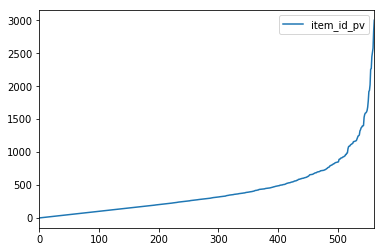

In [126]:
offline_df.groupby(['item_id_pv']).count().sort_index().reset_index()[['item_id_pv']].plot()

In [50]:
offline_df.describe()

,instance_id,item_id,item_brand_id,item_city_id,item_price_level,item_sales_level,item_collected_level,item_pv_level,user_id,user_gender_id,...,context_timestamp,context_page_id,shop_id,shop_review_num_level,shop_review_positive_rate,shop_star_level,shop_score_service,shop_score_delivery,shop_score_description,is_trade
count,4.781380e+05,4.781380e+05,4.781380e+05,4.781380e+05,478138.000000,477225.000000,478138.000000,478138.000000,4.781380e+05,478138.000000,...,4.781380e+05,478138.000000,4.781380e+05,478138.000000,478138.000000,478138.000000,478138.000000,478138.000000,478138.000000,478138.000000
mean,4.613082e+18,4.594622e+18,4.838444e+18,5.500420e+18,6.777175,11.157054,12.199336,17.128676,4.609864e+18,0.213047,...,1.537502e+09,4003.362366,4.733842e+18,15.768353,0.994830,5013.175240,0.971124,0.970497,0.974863,0.018867
std,2.663448e+18,2.710140e+18,2.694756e+18,2.464881e+18,1.089037,2.536297,2.497312,2.160745,2.663355e+18,0.514699,...,1.726222e+05,4.019709,2.596118e+18,2.825294,0.011972,2.590989,0.023817,0.023776,0.025024,0.136055
min,3.823219e+12,6.964907e+14,-1.000000e+00,-1.000000e+00,0.000000,1.000000,0.000000,0.000000,2.477979e+13,-1.000000,...,1.537200e+09,4001.000000,1.543560e+15,0.000000,-1.000000,4999.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,2.308543e+18,2.251088e+18,2.357806e+18,3.948283e+18,6.000000,10.000000,11.000000,16.000000,2.302761e+18,0.000000,...,1.537351e+09,4001.000000,2.498543e+18,14.000000,0.992779,5012.000000,0.966360,0.965684,0.969268,0.000000
50%,4.613478e+18,4.636270e+18,5.051040e+18,6.738284e+18,7.000000,11.000000,12.000000,17.000000,4.608490e+18,0.000000,...,1.537506e+09,4001.000000,4.629590e+18,16.000000,1.000000,5013.000000,0.972347,0.971590,0.978493,0.000000
75%,6.920994e+18,7.007158e+18,7.565625e+18,7.534239e+18,8.000000,13.000000,14.000000,19.000000,6.914375e+18,0.000000,...,1.537635e+09,4004.000000,6.740687e+18,17.000000,1.000000,5015.000000,0.977822,0.976978,0.983640,0.000000
max,9.223362e+18,9.221980e+18,9.222396e+18,9.151271e+18,17.000000,17.000000,17.000000,21.000000,9.223345e+18,2.000000,...,1.537805e+09,4020.000000,9.220773e+18,25.000000,1.000000,5020.000000,1.000000,1.000000,1.000000,1.000000
